<>:8: SyntaxWarning: invalid escape sequence '\i'
<>:8: SyntaxWarning: invalid escape sequence '\i'
C:\Users\witby\AppData\Local\Temp\ipykernel_16752\1745662791.py:8: SyntaxWarning: invalid escape sequence '\i'
  with open('assets\intersection_points_template.json') as f:


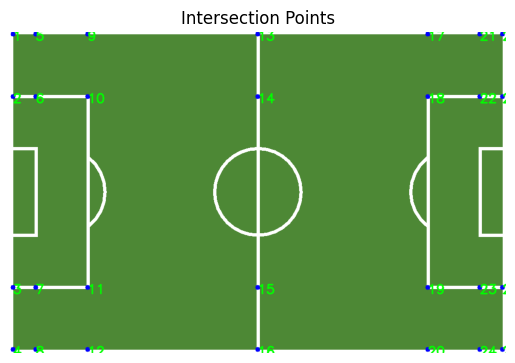

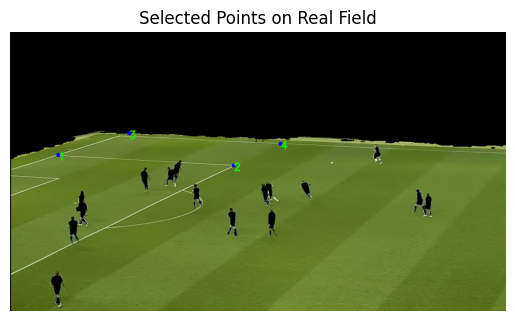

Total number of combinations: 20475
Minimum MSE: 11649.185500217014
Best Combination: ('1', '2', '3', '5')
Best Permutation: ('1', '2', '3', '5')
Minimum MSE: 11638.697215711805
Best Combination: ('1', '2', '3', '5')
Best Permutation: ('1', '2', '5', '3')
Minimum MSE: 11635.25171875
Best Combination: ('1', '2', '3', '5')
Best Permutation: ('1', '3', '2', '5')
Minimum MSE: 11632.989382595486
Best Combination: ('1', '2', '3', '5')
Best Permutation: ('3', '2', '5', '1')
Minimum MSE: 10035.046331380208
Best Combination: ('1', '2', '5', '6')
Best Permutation: ('2', '5', '6', '1')
Minimum MSE: 9196.40029296875
Best Combination: ('1', '2', '5', '6')
Best Permutation: ('5', '2', '1', '6')
Minimum MSE: 8696.659213324652
Best Combination: ('1', '2', '5', '10')
Best Permutation: ('2', '10', '5', '1')
Minimum MSE: 6875.320245225695
Best Combination: ('1', '2', '5', '15')
Best Permutation: ('2', '5', '15', '1')
Minimum MSE: 5285.74105577257
Best Combination: ('1', '2', '6', '9')
Best Permutation: (

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
from itertools import combinations, permutations

# Load intersection points
with open('assets\intersection_points_template.json') as f:
    points_temp = json.load(f)

# Load selected points on the real field
with open('assets/selected_points_real_field.json') as f:
    points_real = json.load(f)

# Function to plot points on image
def plot_points_on_image(image_path, points, title):
    img = cv2.imread(image_path)
    image_with_points = img.copy()
    for point, (x, y) in points.items():
        cv2.circle(image_with_points, (x, y), 5, (255, 0, 0), -1)  # Blue color
        cv2.putText(image_with_points, point, (x, y + 13), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)
    plt.imshow(cv2.cvtColor(image_with_points, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot points on the world cup template image
plot_points_on_image('assets/world_cup_template.png', points_temp, 'Intersection Points')

# Plot points on the green region image
plot_points_on_image('assets/green_region.png', points_real, 'Selected Points on Real Field')

# Function to find homography
def find_homography(src_points, dst_points):
    src = np.array([src_points[pt] for pt in src_points], dtype=np.float32)
    dst = np.array([dst_points[pt] for pt in dst_points], dtype=np.float32)
    H, _ = cv2.findHomography(src, dst)
    return H

# Function to warp image using homography
def warp_image(image_path, H, size):
    img = cv2.imread(image_path)
    warped_img = cv2.warpPerspective(img, H, size)
    return warped_img

# Function to calculate MSE between two images
def calculate_mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

# Get all combinations of 4 points from the template points
combs = list(combinations(points_temp.keys(), 4))
print(f'Total number of combinations: {len(combs)}')

# Size of the reference image
ref_img = cv2.imread('assets/green_region.png')
size = (ref_img.shape[1], ref_img.shape[0])

# Find minimum MSE and corresponding combination and permutation
min_mse = float('inf')
best_comb = None
best_perm = None

for comb in combs:
    for perm in permutations(comb):
        src_points = points_real
        dst_points = {str(i+1): points_temp[pt] for i, pt in enumerate(perm)}
        H = find_homography(src_points, dst_points)
        
        # Ensure H is of the correct type and size
        if H is None or H.shape != (3, 3):
            continue
        
        # Convert H to float32 type if it is not already
        H = H.astype(np.float32)
        
        try:
            warped_img = warp_image('assets/world_cup_template.png', H, size)
            mse = calculate_mse(ref_img, warped_img)
            if mse < min_mse:
                min_mse = mse
                best_comb = comb
                best_perm = perm

                print(f'Minimum MSE: {min_mse}')
                print(f'Best Combination: {best_comb}')
                print(f'Best Permutation: {best_perm}')
        except cv2.error as e:
            print(f"cv2.error: {e}")
            continue

print(f'Minimum MSE: {min_mse}')
print(f'Best Combination: {best_comb}')
print(f'Best Permutation: {best_perm}')
